In [1]:
import pandas as pd

df = pd.read_csv("data/raw/data.csv", encoding="ISO-8859-1")

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
df.shape

(541909, 8)

In [3]:
df.column

AttributeError: 'DataFrame' object has no attribute 'column'

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='str')

In [5]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [6]:
df['CustomerID'].isnull().sum()


np.int64(135080)

In [7]:
df = df.dropna(subset=['CustomerID'])


In [8]:
df.shape

(406829, 8)

In [9]:
(df['Quantity'] <= 0).sum()


np.int64(8905)

In [10]:
df = df[df['Quantity'] > 0]


In [11]:
df.shape

(397924, 8)

In [12]:
(df['UnitPrice'] <= 0).sum()


np.int64(40)

In [13]:
df = df[df['UnitPrice'] > 0]
df.shape


(397884, 8)

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [15]:
df.shape

(397884, 8)

In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [17]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [18]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [19]:
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [20]:
rfm.shape()


TypeError: 'tuple' object is not callable

In [21]:
rfm.shape

(4338, 3)

In [22]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


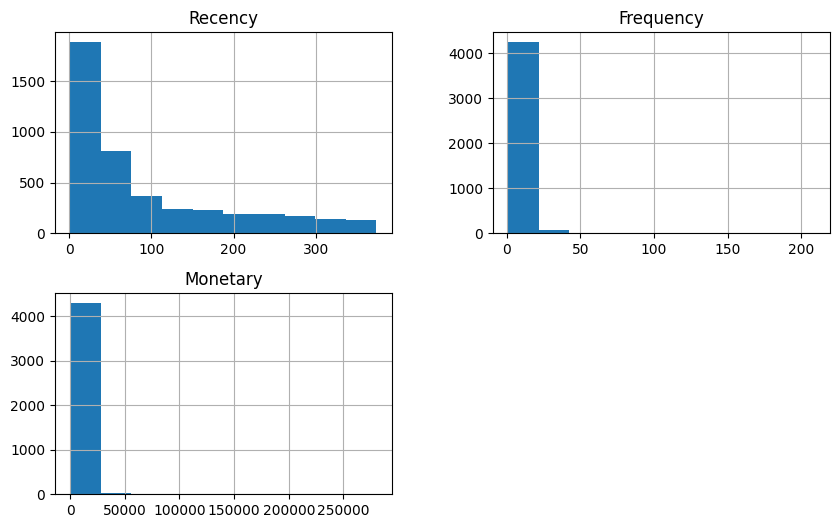

In [23]:
import matplotlib.pyplot as plt

rfm.hist(figsize=(10,6))
plt.show()


In [24]:
import numpy as np

rfm_log = rfm.copy()

rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

rfm_log.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.789960,0.693147,11.253955
12347.0,1.098612,2.079442,8.368925
12348.0,4.330733,1.609438,7.494564
12349.0,2.995732,0.693147,7.472245
12350.0,5.739793,0.693147,5.815324


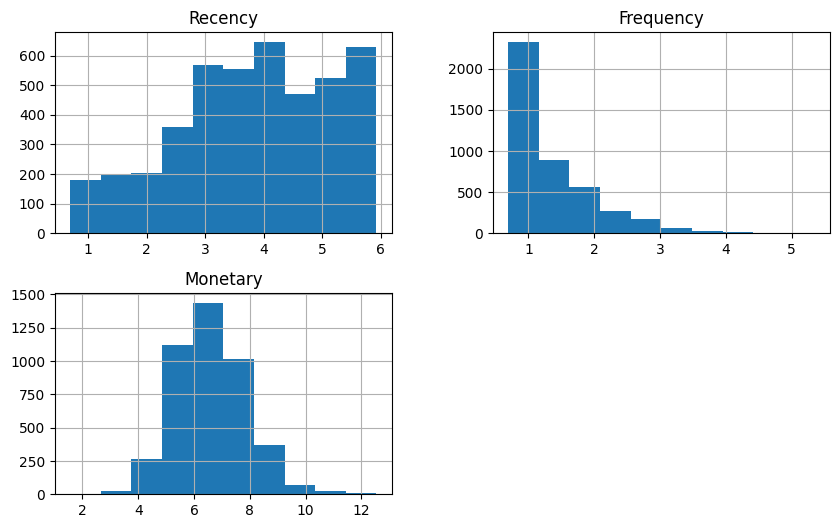

In [25]:
rfm_log.hist(figsize=(10,6))
plt.show()


In [26]:

unique_products = df.groupby('CustomerID')['StockCode'].nunique()

total_quantity = df.groupby('CustomerID')['Quantity'].sum()

rfm['UniqueProducts'] = unique_products
rfm['TotalQuantity'] = total_quantity

rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

rfm['AvgQuantityPerOrder'] = rfm['TotalQuantity'] / rfm['Frequency']

rfm.head()


,Recency,Frequency,Monetary,UniqueProducts,TotalQuantity,AvgOrderValue,AvgQuantityPerOrder
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,74215,77183.600000,74215.000000
12347.0,2,7,4310.00,103,2458,615.714286,351.142857
12348.0,75,4,1797.24,22,2341,449.310000,585.250000
12349.0,19,1,1757.55,73,631,1757.550000,631.000000
12350.0,310,1,334.40,17,197,334.400000,197.000000


In [27]:
rfm.shape

(4338, 7)

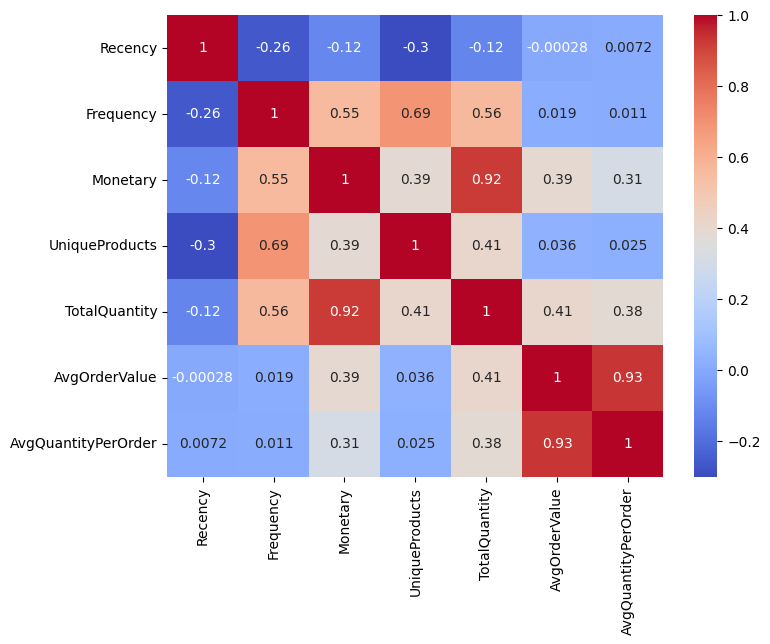

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')
plt.show()


In [29]:
rfm = rfm.drop(columns=['TotalQuantity', 'AvgQuantityPerOrder'])
rfm.shape


(4338, 5)

In [30]:
import numpy as np

rfm_log = np.log1p(rfm)
rfm_log.head()


,Recency,Frequency,Monetary,UniqueProducts,AvgOrderValue
CustomerID,,,,,
12346.0,5.789960,0.693147,11.253955,0.693147,11.253955
12347.0,1.098612,2.079442,8.368925,4.644391,6.424406
12348.0,4.330733,1.609438,7.494564,3.135494,6.109936
12349.0,2.995732,0.693147,7.472245,4.304065,7.472245
12350.0,5.739793,0.693147,5.815324,2.890372,5.815324


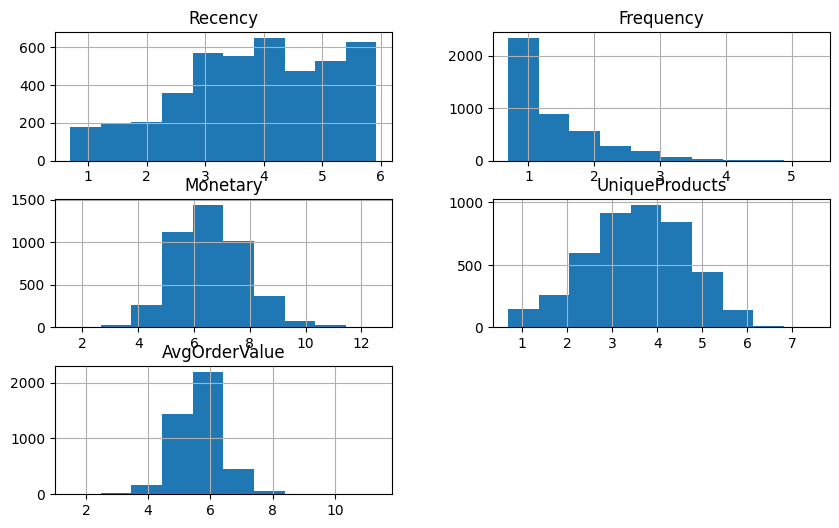

In [31]:
rfm_log.hist(figsize=(10,6))
plt.show()


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled[:5]


array([[ 1.46199281, -0.95521426,  3.70622476, -2.52637584,  7.52348263],
       [-2.03873442,  1.07442519,  1.41184341,  0.96588114,  1.03840787],
       [ 0.37310424,  0.38630445,  0.7164889 , -0.36773818,  0.61614095],
       [-0.62308592, -0.95521426,  0.6987394 ,  0.66508847,  2.44543655],
       [ 1.42455753, -0.95521426, -0.6189622 , -0.58438658,  0.22053813]])

In [33]:
rfm_scaled.shape


(4338, 5)

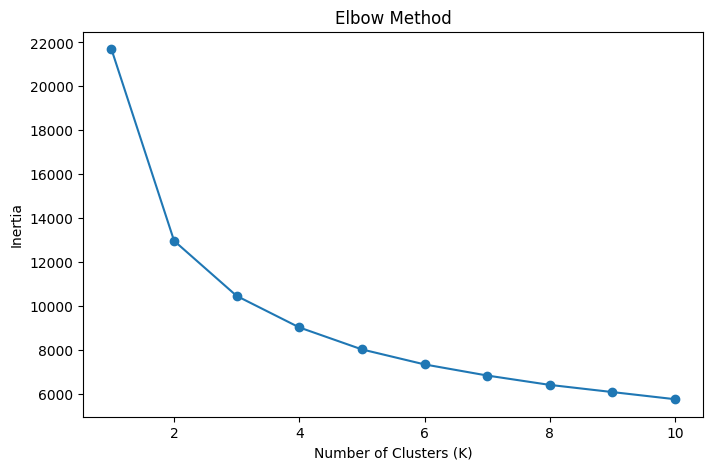

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [35]:
from sklearn.metrics import silhouette_score

for k in [3,4,5,6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")


K=3, Silhouette Score=0.2531
K=4, Silhouette Score=0.2382
K=5, Silhouette Score=0.2333
K=6, Silhouette Score=0.2190


In [36]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,UniqueProducts,AvgOrderValue,Cluster
CustomerID,,,,,,
12346.0,326,1,77183.60,1,77183.600000,2
12347.0,2,7,4310.00,103,615.714286,1
12348.0,75,4,1797.24,22,449.310000,2
12349.0,19,1,1757.55,73,1757.550000,2
12350.0,310,1,334.40,17,334.400000,0


In [37]:
rfm['Cluster'].value_counts()


Cluster
2    1887
0    1309
1    1142
Name: count, dtype: int64

In [38]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 1.2773308799921705


In [39]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3)
hier_labels = hierarchical.fit_predict(rfm_scaled)

# Evaluate
sil_score_h = silhouette_score(rfm_scaled, hier_labels)
db_score_h = davies_bouldin_score(rfm_scaled, hier_labels)

print("Hierarchical Silhouette:", sil_score_h)
print("Hierarchical Davies-Bouldin:", db_score_h)


Hierarchical Silhouette: 0.20830611413011607
Hierarchical Davies-Bouldin: 1.4557776615969702


In [40]:

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(rfm_scaled)

# Count clusters
import numpy as np
print("Unique labels:", np.unique(db_labels))
print("Number of clusters (excluding noise):", len(set(db_labels)) - (1 if -1 in db_labels else 0))

# Evaluate only if more than 1 cluster
if len(set(db_labels)) > 1:
    sil_score_db = silhouette_score(rfm_scaled, db_labels)
    db_score_db = davies_bouldin_score(rfm_scaled, db_labels)
    print("DBSCAN Silhouette:", sil_score_db)
    print("DBSCAN Davies-Bouldin:", db_score_db)


Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of clusters (excluding noise): 15
DBSCAN Silhouette: -0.14873334575380015
DBSCAN Davies-Bouldin: 1.8494876668044125


In [41]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(rfm_scaled)

sil_score_gmm = silhouette_score(rfm_scaled, gmm_labels)
db_score_gmm = davies_bouldin_score(rfm_scaled, gmm_labels)

print("GMM Silhouette:", sil_score_gmm)
print("GMM Davies-Bouldin:", db_score_gmm)


GMM Silhouette: 0.14003455106890178
GMM Davies-Bouldin: 1.8110126330805798


In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

rfm_pca = pca.fit_transform(rfm_scaled)

rfm_pca[:5]


array([[ 2.34495391,  7.52918648],
       [ 2.85247791, -0.35312101],
       [ 0.46795089,  0.66309207],
       [ 1.29018954,  2.01389837],
       [-1.53123953,  1.1097703 ]])

In [43]:
pca.explained_variance_ratio_


array([0.6177911 , 0.20456639])

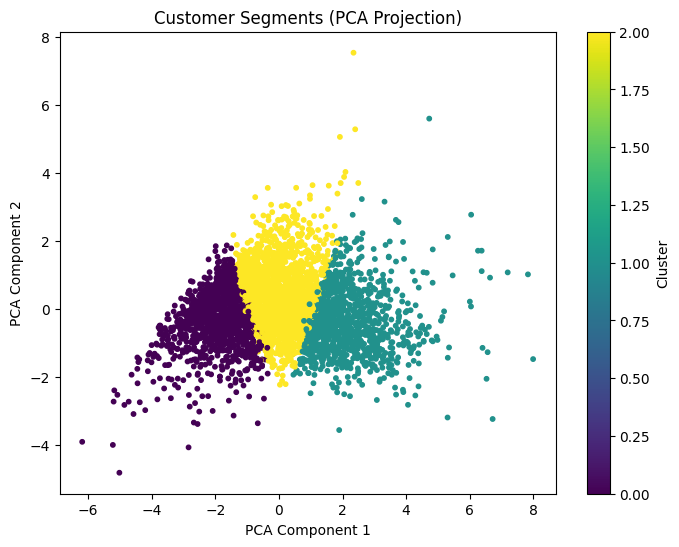

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster'], cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA Projection)')
plt.colorbar(label='Cluster')
plt.show()


In [45]:
cluster_summary = rfm.groupby('Cluster').mean()
cluster_summary


,Recency,Frequency,Monetary,UniqueProducts,AvgOrderValue
Cluster,,,,,
0,162.505730,1.451490,227.495225,14.064935,172.170800
1,20.880911,10.572680,5887.220876,139.784588,564.154785
2,87.364600,2.415474,1001.807321,47.030737,502.759418


In [46]:
rfm.groupby('Cluster')['Monetary'].sum()


Cluster
0     297791.250
1    6723206.240
2    1890410.414
Name: Monetary, dtype: float64

In [47]:
total_revenue = rfm['Monetary'].sum()

revenue_percent = (rfm.groupby('Cluster')['Monetary'].sum() / total_revenue) * 100
revenue_percent


Cluster
0     3.341686
1    75.444939
2    21.213375
Name: Monetary, dtype: float64

In [48]:
customer_percent = (rfm['Cluster'].value_counts(normalize=True)) * 100
customer_percent


Cluster
2    43.499308
0    30.175196
1    26.325496
Name: proportion, dtype: float64

In [49]:
rfm.groupby('Cluster')['Monetary'].mean()


Cluster
0     227.495225
1    5887.220876
2    1001.807321
Name: Monetary, dtype: float64

In [50]:
cluster_summary.to_csv("cluster_summary.csv")


In [51]:
revenue_percent.to_csv("revenue_percent.csv")
customer_percent.to_csv("customer_percent.csv")


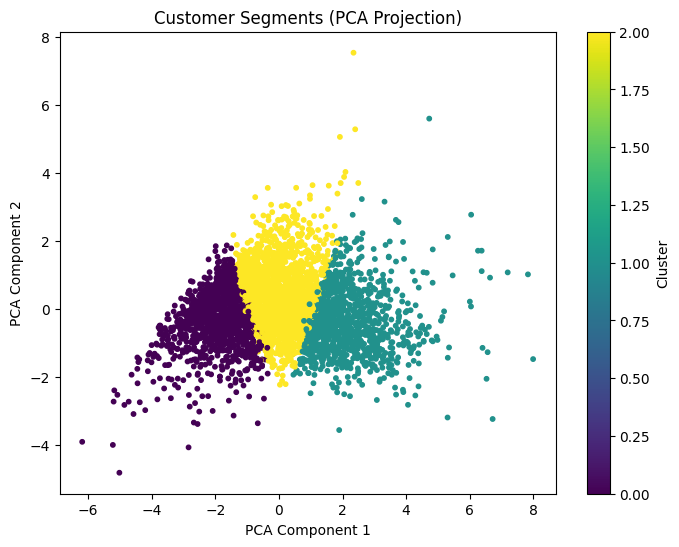

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster'], cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA Projection)')
plt.colorbar(label='Cluster')
plt.savefig("pca_clusters.png")
plt.show()
